In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, BatchNormalization
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split

In [2]:
# Lista de archivos CSV de diferentes empresas
companies = ["AAPL.csv", "MSFT.csv", "GOOGL.csv", "AMZN.csv", "TSLA.csv"]

# Cargar y combinar los datasets
dataframes = []
for file in companies:
    df = pd.read_csv(f"../Data/{file}")  
    dataframes.append(df)

# Unir todos los datos en un solo DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Seleccionar características
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_signal',
               #'weighted_sentiment', 'sentiment_momentum', 'tweet_count'
               ]]

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Crear ventanas temporales
def create_dataset(dataset, target_column_index, time_step=20):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i + time_step), :])
        dataY.append(dataset[i + time_step, target_column_index])
    return np.array(dataX), np.array(dataY)

# Índice de la columna 'Close'
target_column_index = 3  
X, y = create_dataset(scaled_data, target_column_index, time_step=20)

# Dividir en entrenamiento (80%), validación (10%) y prueba (10%)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"Datos de entrenamiento: {X_train.shape}, Datos de validación: {X_val.shape}, Datos de prueba: {X_test.shape}")

Datos de entrenamiento: (8239, 20, 10), Datos de validación: (1029, 20, 10), Datos de prueba: (1031, 20, 10)


In [4]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs  # Residual connection

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)

    return x + res

# Datos de entrada
seq_length = 20  # Longitud de la ventana
num_features = 10  # Número de variables

inputs = Input(shape=(seq_length, num_features))


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = Input(shape=(seq_length, num_features))
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="elu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1, activation="linear")(x) #this is a pass-through
    return Model(inputs, outputs)


In [5]:
input_shape = X_train.shape[1:]
print(input_shape)

model = build_model(
    input_shape,
    head_size=64, # Embedding size for attention
    num_heads=32, # Number of attention heads
    ff_dim=128, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=4,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.1,
)

model.compile(
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=1e-5),
    metrics=["mean_squared_error"],
)

# Resumen del modelo
model.summary()

(20, 10)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 10)    │         20 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 10)    │     88,074 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 10)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 10)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 10)    │         20 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20, 128)   │      1,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20, 10)    │      1,290 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 10)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 10)    │         20 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 10)    │     88,074 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 20, 10)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 20, 10)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 10)    │         20 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20, 128)   │      1,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 20, 128)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 20, 10)    │      1,290 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 20, 10)    │          0 │ dense_3[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 368,881 (1.41 MB)

 Trainable params: 368,881 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Callbacks ajustados
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 0.6470 - mean_squared_error: 0.6470
Epoch 1: val_loss improved from inf to 0.10129, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 418ms/step - loss: 0.6453 - mean_squared_error: 0.6453 - val_loss: 0.1013 - val_mean_squared_error: 0.1013 - learning_rate: 1.0000e-05
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 0.2544 - mean_squared_error: 0.2544
Epoch 2: val_loss improved from 0.10129 to 0.08795, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 413ms/step - loss: 0.2539 - mean_squared_error: 0.2539 - val_loss: 0.0879 - val_mean_squared_error: 0.0879 - learning_rate: 1.0000e-05
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 0.1702 - mean_squared_error: 0.1702
Epoch 3: val_loss improved from 0.08795 to 0.06734, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - loss: 0.1701 - mean_squared_error: 0.1701 - val_loss: 0.0673 - val_mean_squared_er

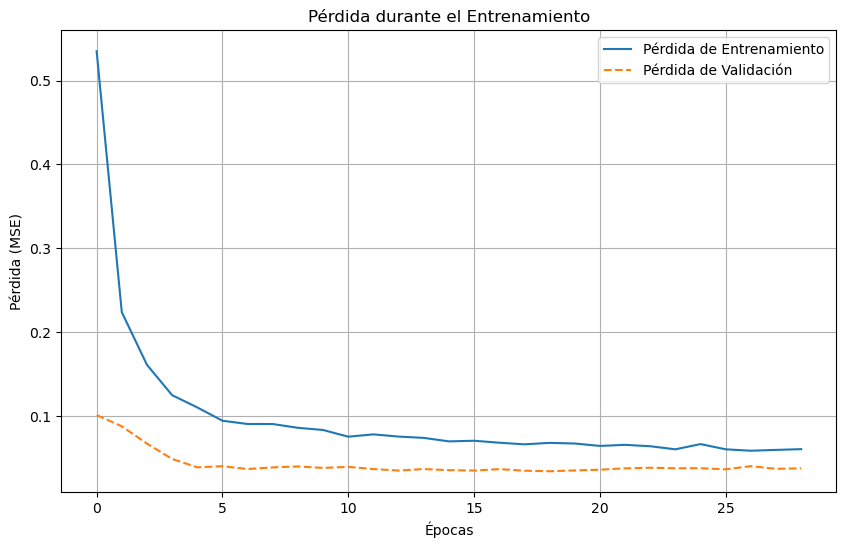

In [7]:
# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación', linestyle='--')
plt.title("Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.legend()
plt.grid()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0341 - mean_squared_error: 0.0341
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


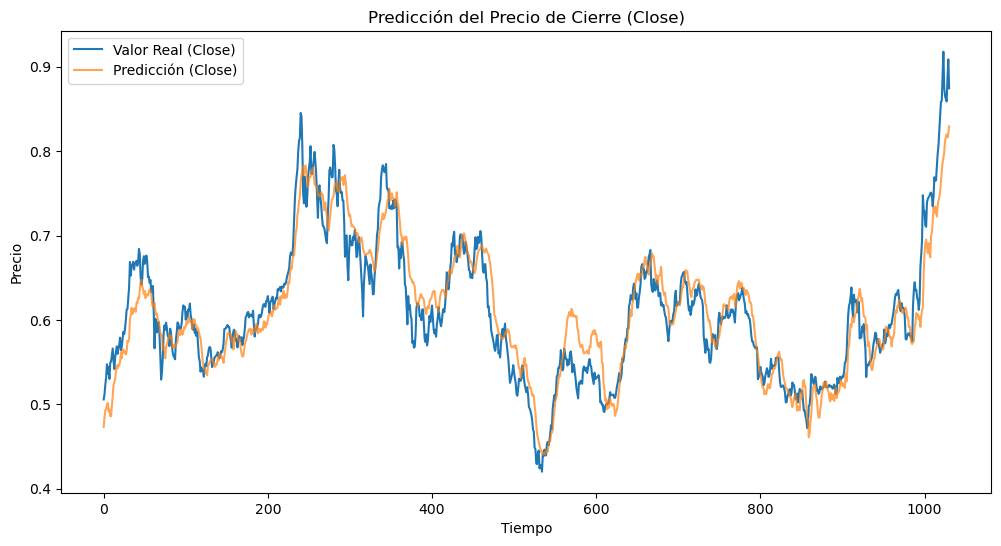

In [8]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test, verbose=1)
# print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

# Realizar predicciones
y_pred = model.predict(X_test)

# Desescalado de las predicciones (opcional, si deseas devolver los valores a la escala original)
y_test_original = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], X_test.shape[2]-1)), y_test.reshape(-1, 1)), axis=1)
)[:, -1]

y_pred_original = scaler.inverse_transform(
    np.concatenate((np.zeros((y_pred.shape[0], X_test.shape[2]-1)), y_pred), axis=1)
)[:, -1]

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Valor Real (Close)")
plt.plot(y_pred_original, label="Predicción (Close)", alpha=0.7)
plt.title("Predicción del Precio de Cierre (Close)")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.legend()
plt.show()
